In [13]:
import os
from pathlib import Path
from src.visualization.visualize import visualize_sample
from src.data.dataset import KittiDataset

raw_path = str(Path(os.path.abspath('')).resolve().parents[0] / "data" / "raw")
processed_path = str(Path(os.path.abspath('')).resolve().parents[0] / "data" / "processed" / "cropped")

# training_dataset_raw = KittiDataset(root_dir=raw_path, load_raw=False, downsample_lidar=False)
training_dataset_processed = KittiDataset(root_dir=processed_path, train=True, load_raw=False, downsample_lidar=True)
validation_dataset = KittiDataset(root_dir=processed_path, train=False, load_raw=False)

In [2]:
print(f"Training data - {len(training_dataset_processed)}")
print(f"Validation data - {len(validation_dataset)}")

Training data - 85898
Validation data - 6852


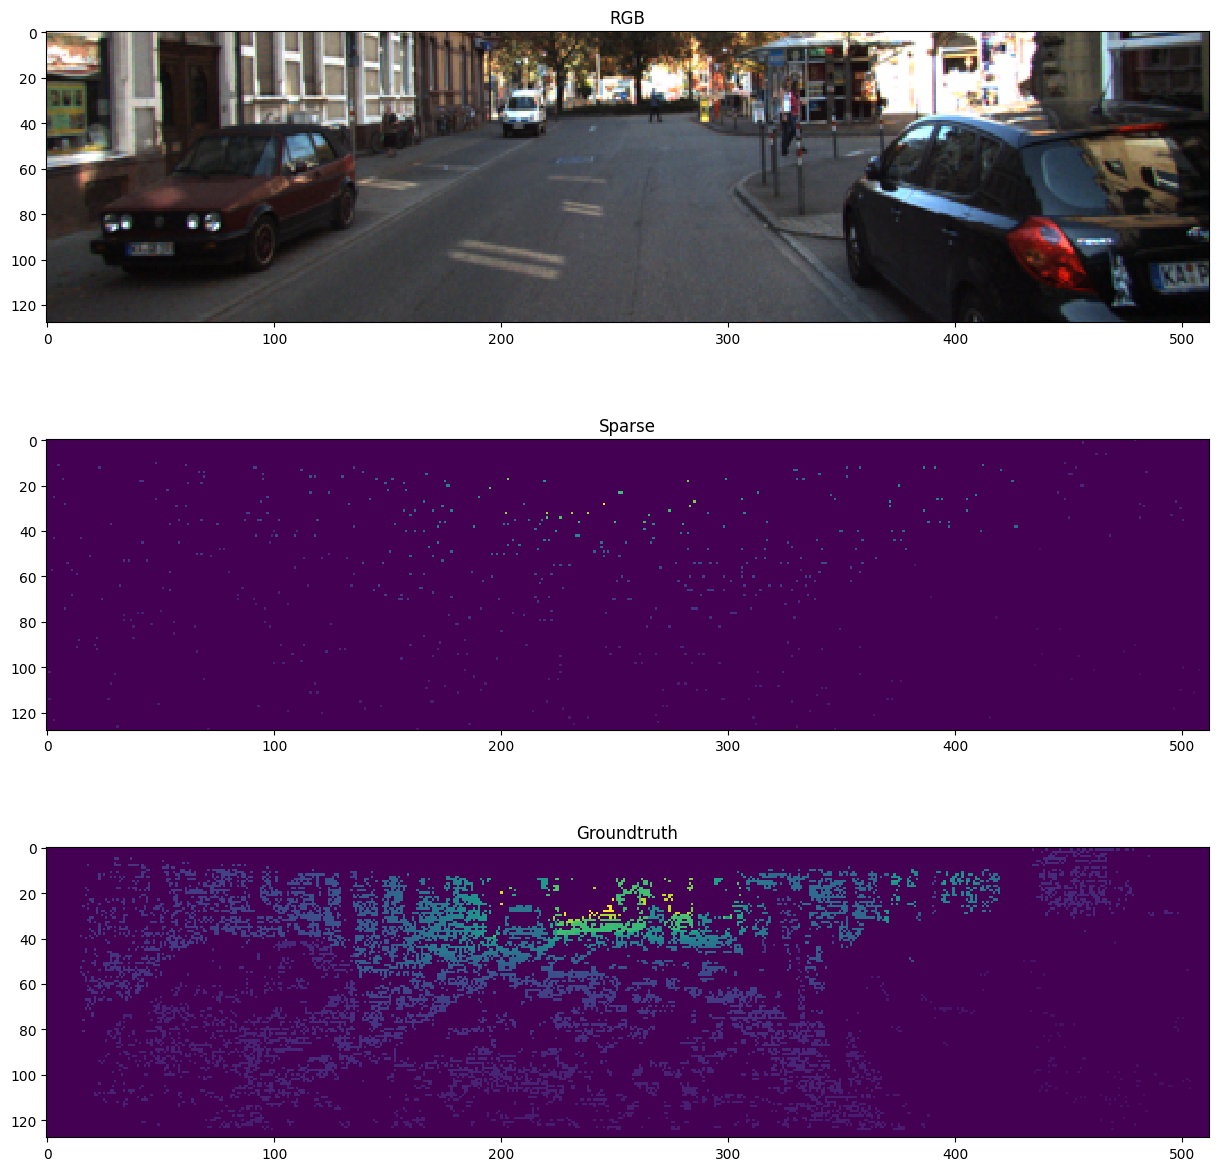

In [3]:
visualize_sample(training_dataset_processed[9999])

### LiDAR downsampling

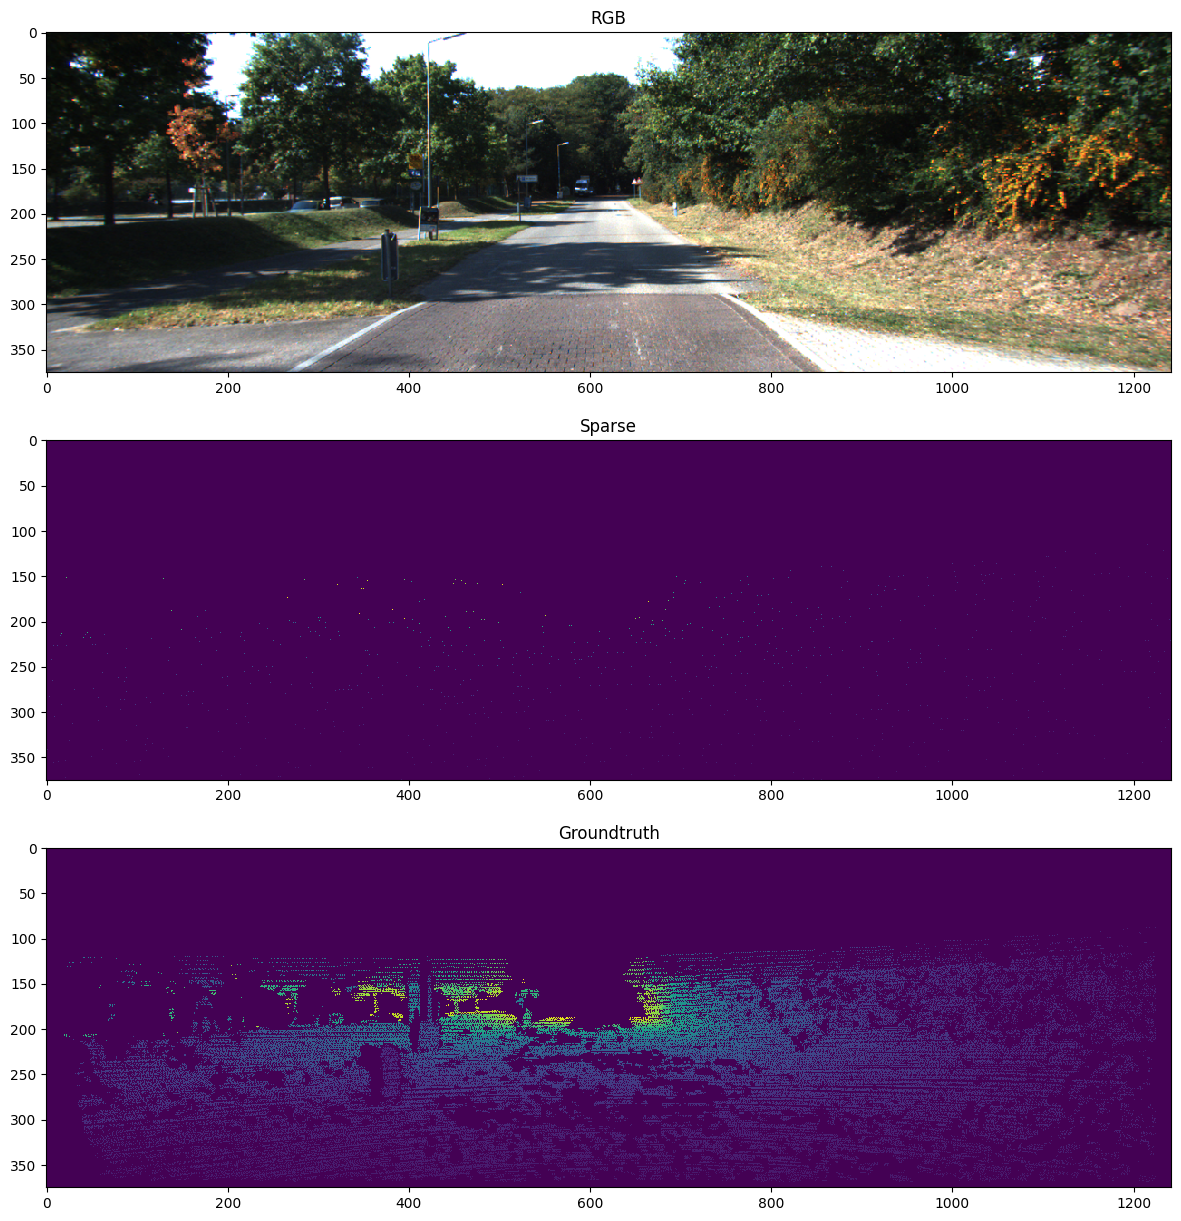

In [4]:
training_dataset_downsample = KittiDataset(downsample_lidar=True)
visualize_sample(training_dataset_downsample[1000])

In [2]:
from src.models.training.train_model import train_model
from src.models.training.config import TrainingConfig


config = TrainingConfig(
    output_path=str(Path(os.path.abspath('')).resolve().parents[0] / "models" / "trainings"),
    epochs=50,
    batch_size=32,
    dataset_path=processed_path,
    learning_rate=1e-3
)

train_model(config)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/devolay/depth-completion/e/DEP-15


/Users/dawid/anaconda3/envs/depth-completion-mp/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/dawid/Private/School/Sem 1/Machine Perception/Project/depth-completion-mp/models/trainings exists and is not empty.

  | Name  | Type            | Params
------------------------------------------
0 | model | uncertainty_net | 2.5 M 
------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.181    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/dawid/anaconda3/envs/depth-completion-mp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


> /Users/dawid/Private/School/Sem 1/Machine Perception/Project/depth-completion-mp/src/data/dataset.py(120)__getitem__()
    118         import pdb; pdb.set_trace()
    119 
--> 120         if self.train:
    121             if np.random.uniform(0.0, 1.0) > 0.5:
    122                 input, gt = F.hflip(input), F.hflip(gt)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  .

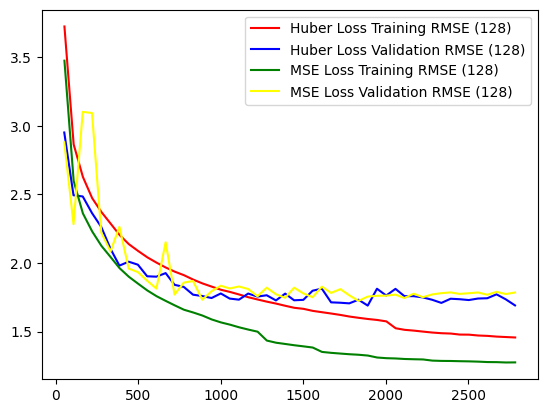

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

training_logs = pd.read_csv("huber-loss-128-metrics.csv")
training_logs2 = pd.read_csv("mse_loss_sampling-128.csv")
training_logs3 = pd.read_csv("mse_loss_sampling_500.csv")
plt.plot(training_logs['train_rmse_epoch'].dropna(), color='red', label='Huber Loss Training RMSE (128)')
plt.plot(training_logs['valid_rmse'].dropna(), color='blue', label='Huber Loss Validation RMSE (128)')
plt.plot(training_logs2['train_rmse_epoch'].dropna(),color='green', label='MSE Loss Training RMSE (128)')
plt.plot(training_logs2['valid_rmse'].dropna(), color='yellow', label='MSE Loss Validation RMSE (128)')
# plt.plot(training_logs3['train_rmse_epoch'].dropna(),color='purple', label='MSE Loss Training RMSE 500')
# plt.plot(training_logs3['valid_rmse'].dropna(), color='orange', label='MSE Loss Validation RMSE 500')
plt.legend()
plt.show()

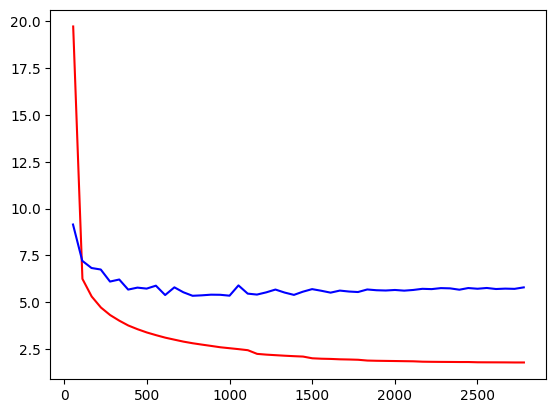

In [2]:
plt.plot(training_logs['train_loss_epoch'].dropna(), label='Training Loss', color='red')
plt.plot(training_logs['valid_loss'].dropna(), label='Validation Loss', color='blue')
plt.show()

In [18]:
from src.models.model import uncertainty_net
import torch
from torch.utils.data import DataLoader

model_path = "huber-loss-128-sampling.ckpt"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

model = uncertainty_net(4)
# Remove model. prefix from keys
checkpoint['state_dict'] = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
model.load_state_dict(checkpoint['state_dict'])
model.eval()

validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, pin_memory=True, drop_last=True)

In [19]:
predictions = []
for i, sample in enumerate(validation_loader):
    if i < 10:
        (input, gt) = sample
        sparse, rgb = input[:, 0:1], input[:, 1:4]
        rgb = rgb / 255.
        _, _, output, _ = model(input)
        output = torch.clamp(output, min=0, max=85)
        output = output[0][0:1].cpu().detach().numpy()
        predictions.append((
            (rgb.numpy().squeeze(0), sparse.numpy().squeeze(0), gt.numpy().squeeze(0)),
            output
        ))
    else:
        break

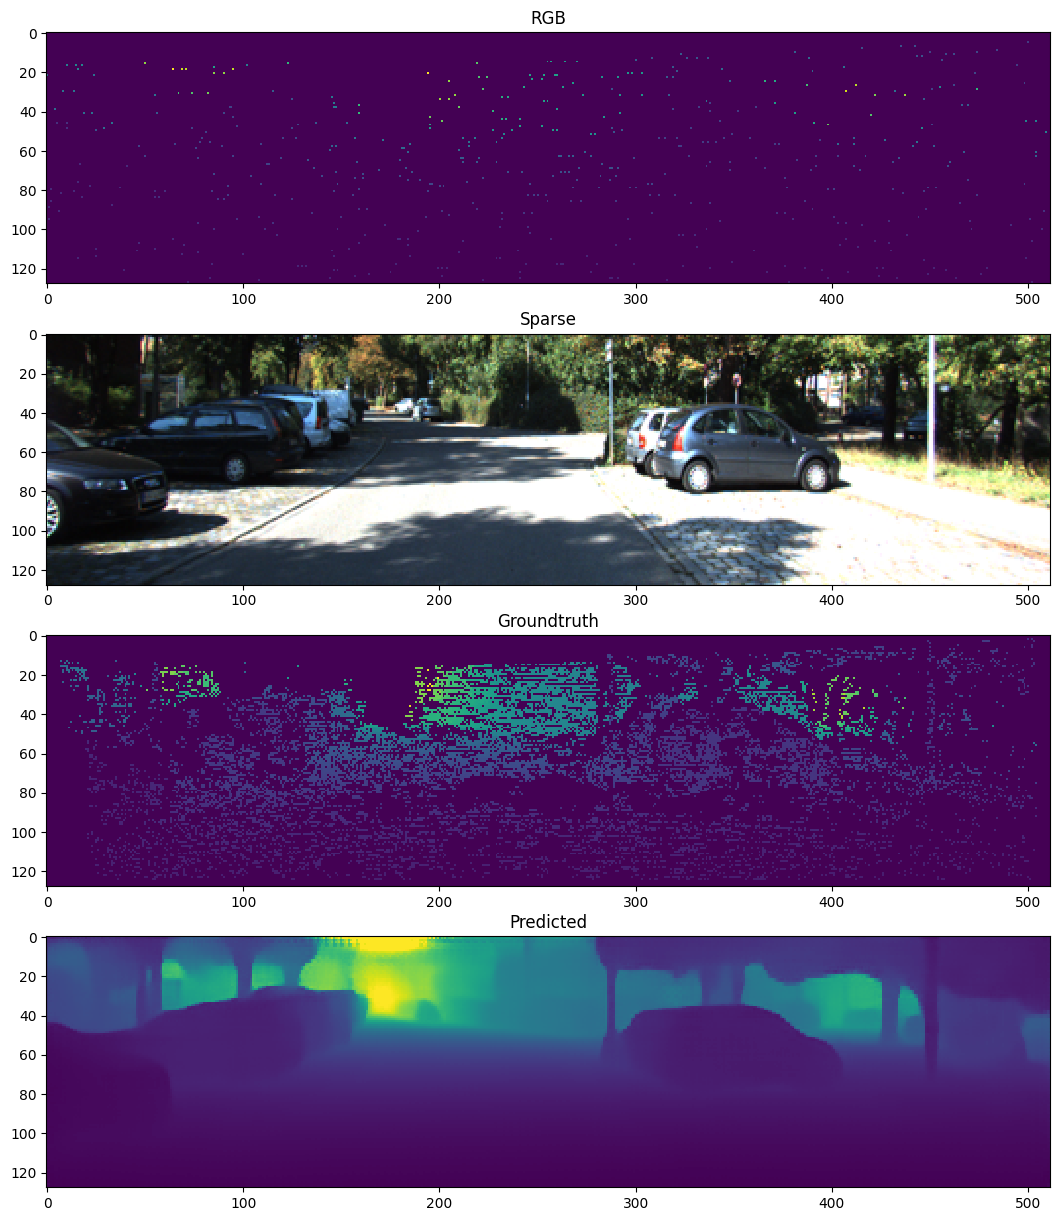

In [20]:
visualize_sample(sample=predictions[0][0], prediction=predictions[0][1])